In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Climate Analysis

### Precipitation Analysis
-Design a query to retrieve the last 12 months of precipitation data and plot the results

In [12]:
# Get a list of column names and types
measure_columns = inspector.get_columns('measurement')
for c in measure_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Find the last date in the table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [14]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [15]:
# Perform a query to retrieve the date and precipitation scores
sel = [Measurement.date,Measurement.prcp]
query_table = session.query(*sel).filter(Measurement.date >= query_date).all()

In [16]:
# Sort the dataframe by date
precipitation_df = pd.DataFrame(query_table, columns = ['Date','Precipitation'])
precipitation_df = precipitation_df.dropna(how = 'any')
precipitation_df = precipitation_df.sort_values(["Date"], ascending=True)

In [17]:
precipitation_df = precipitation_df.set_index("Date")
precipitation_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


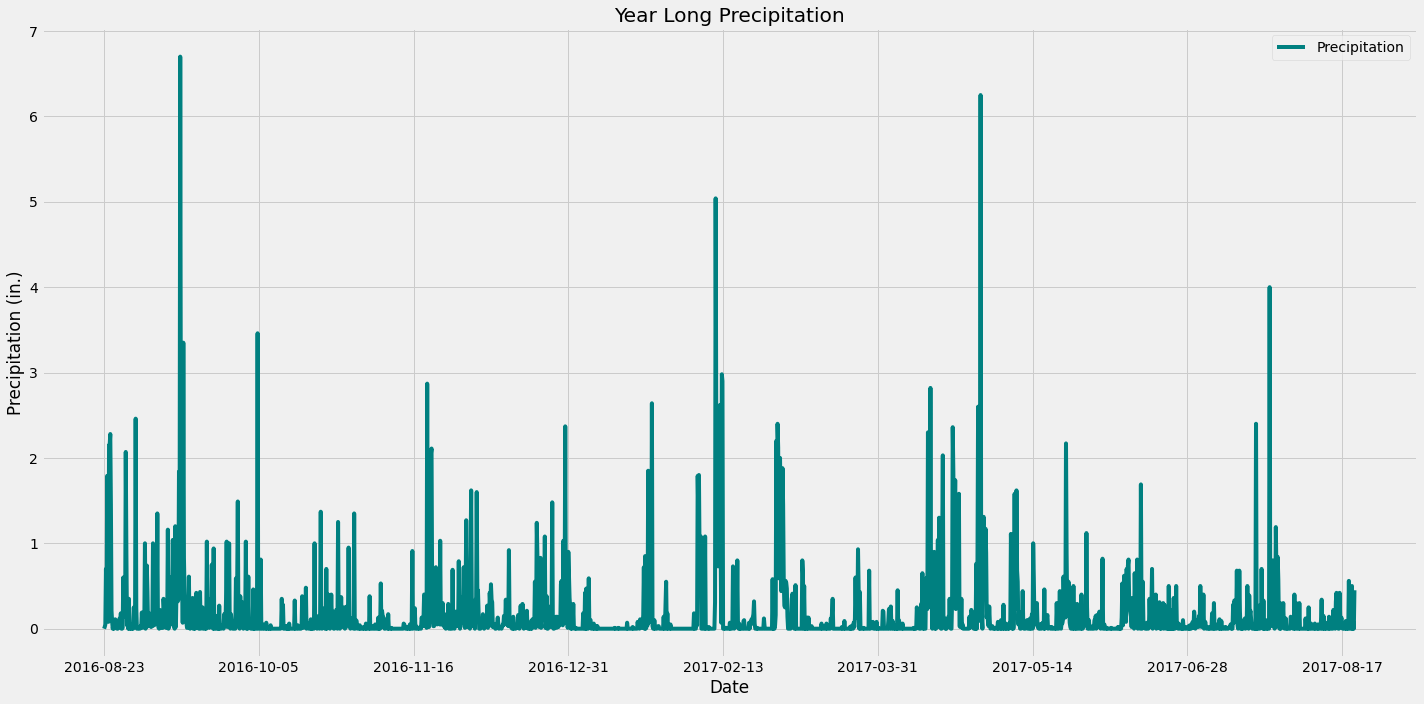

In [57]:
# Plot the results using the DataFrame plot method.
fig, ax = plt.subplots(figsize = (20, 10))
precipitation_df.plot(ax = ax, x_compat = True, color = "Teal")

#title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Year Long Precipitation")

plt.savefig("Images/precipitation1.png")

#plot
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [30]:
# Get a list of column names and types
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [22]:
# Design a query to show how many stations are available in this dataset?
station_number = session.query(Station).count()
print(f"There are {station_number} stations")

There are 9 stations


In [25]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                   group_by(Measurement.station).\
                   order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
usc281_data = session.query(*sel).filter(Measurement.station == "USC00519281").all()
usc281_data

[(54.0, 85.0, 71.66378066378067)]

In [39]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date,Measurement.tobs]
query_table = session.query(*sel).filter(Measurement.date >= query_date).\
                                  filter(Measurement.station == "USC00519281").\
                                  order_by(Measurement.date).all()

In [42]:
# Create pandas df and sort temp in asc order
usc281_df = pd.DataFrame(query_table, columns = ['Date','TOBS'])
usc281_df = usc281_df.dropna(how = 'any')
usc281_df = usc281_df.set_index("Date")
usc281_df

,TOBS
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


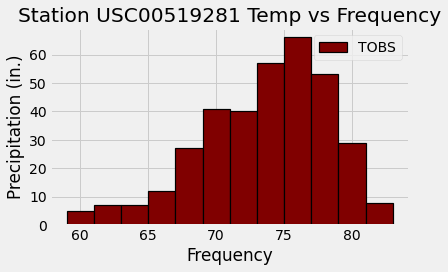

In [55]:
# Plot the Results as a Histogram with `bins=12`
usc281_df.plot.hist(bins = 12, title= "Station USC00519281 Temp vs Frequency",
                    color = "Maroon", edgecolor='black', linewidth=1.2)

#title and labels
plt.xlabel('Frequency')
plt.ylabel('Precipitation (in.)')

plt.savefig("Images/tempvsfreq1.png")

#plot
plt.tight_layout()
plt.show()